In [1]:
import os
import numpy as np
from tqdm import tqdm
import json
import glob

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams["font.family"] = "Palatino"
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,10]})

from utils.rl_glue import RLGlue

In [2]:
def all_files_with_prefix_and_suffix(location, prefix, suffix):
    """returns a list of all files in the 'location' starting with the given prefix"""
    if location[-1] != '/':
        location += '/'
    files = glob.glob(location + prefix + '*' + suffix)

    return files

## A. Control experiments

### A1. Domain: AccessControl

In [3]:
### To run the experiments with RVI-Q and Diff-Q:

# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AccessControl_diff-q.json --output-folder results/control/AccessControl
# python run_exp.py --exp run_exp_learning_control_no_eval --config-file config_files/control_AccessControl_rvi-q.json --output-folder results/control/AccessControl

### These use sample configuration files. Using them as is will result in LONG runtimes. 
### Try a single hyperparameter configuration, or split them the grid of configurations 
### appropriately for the compute resources available

In [4]:
def parse_data_ac(filename_prefix, item, location='../results/', param1='alpha_w', param2='dummy',
               title=None, firstn=-1, type='heatmap', num_sa=None, logbase=-1, ylabel='RMSVE\n(TVR)'):

    files = all_files_with_prefix_and_suffix(location, filename_prefix, '*.npy')
    data_all = {}
    assert len(files) > 0, 'No files found with the prefix: ' + location + filename_prefix
    print(f'{"Filename":<10}{param1:<20}{param2:<10}{"Mean":<10}{"Std. error":<10}')
    for file in files:
        data = np.load(file, allow_pickle=True).item()
        param1_value = data['params']['agent_parameters'][param1]
        if param1_value not in data_all:
            data_all[param1_value] = {}
        param2_value = data['params']['agent_parameters'][param2] if param2!='dummy' else -1
        if param2_value not in data_all[param1_value]:
            data_all[param1_value][param2_value] = {}
        data_to_eval = data[item][:,:firstn]
        mean = np.mean(data_to_eval)
        stderr = np.std(data_to_eval) / np.sqrt(data_to_eval.size)
        data_all[param1_value][param2_value] = (mean, stderr)
        print(f'{file[-10:-4]:<10s}{param1_value:<20.6g}{param2_value:<10.6g}{mean:<10.6g}{stderr:<10.6g}')

    X = sorted(data_all)
    Y = sorted(data_all[np.random.choice(list(data_all.keys()))])
    Z_mean = np.zeros((len(X), len(Y)))
    Z_stderr = np.zeros((len(X), len(Y)))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            try:
                Z_mean[i][j] = data_all[x][y][0]
                Z_stderr[i][j] = data_all[x][y][1]
            except:
                Z_mean[i][j] = np.nan
                Z_stderr[i][j] = np.nan

    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    for i, param_value in enumerate(X):
        ax.errorbar(Y, Z_mean[i], yerr=Z_stderr[i], label=param1+'='+str(param_value))#, color='color')
    ax.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
#     plt.xlabel(param2)
#     plt.ylabel('RMSVE\n(TVR)', rotation=0, labelpad=40)
#     ax.set_title(title)
    plt.ylim(2.05, 2.6)
    if logbase != -1:
        plt.xscale('log', base=logbase)
    ax.set_xticks(Y)
    ax.set_xticklabels(Y)

    fig.tight_layout()
    path = location + title + '.png'
    if not os.path.isfile(path):
        plt.savefig(path, dpi=1200)
    plt.show()

In [6]:
parse_data_ac('AC_DiffQ_eps_0.1', 'rewards_all_train', param1='eta', param2='alpha_w',
               title='AC_DiffQ_eps_0.1_sensitivity', location='./results/control/AccessControl/',
               firstn=-1, type='u-curves', logbase=10, ylabel='Average\nreward\nover\ntraining')

AssertionError: No files found with the prefix: ./results/control/AccessControl/test

Filename  reference_state     alpha_w   Mean      Std. error
1-6_43    3                   0.1       2.5099    0.00200561
1-6_38    11                  0.1       2.57464   0.00203107
1-6_26    27                  0.00625   2.1594    0.00179104
1-6_39    11                  0.4       2.41104   0.00199496
1-6_36    11                  0.00625   2.53955   0.00198964
1-6_34    19                  0.4       2.39117   0.00201784
1-6_23    35                  0.1       2.17565   0.00180944
1-6_31    19                  0.00625   2.24095   0.00184833
1-6_42    3                   0.025     2.5378    0.0019759 
1-6_35    11                  0.0015625 2.34141   0.00189957
1-6_20    35                  0.0015625 2.17986   0.00179017
1-6_17    43                  0.025     2.18211   0.00181697
1-6_41    3                   0.00625   2.42527   0.00189807
1-6_24    35                  0.4       2.11316   0.00184082
1-6_33    19                  0.1       2.55716   0.00203705
1-6_22    35            

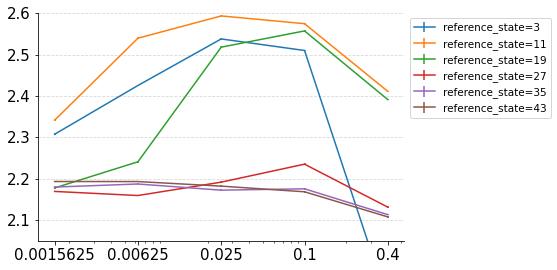

In [149]:
parse_data_ac('AC_RVIQ_eps_0.1', 'rewards_all_train', param1='reference_state', param2='alpha_w',
               title='AC_RVIQ_eps_0.1_sensitivity', location='./results/control/AccessControl/',
               firstn=-1, type='u-curves', logbase=10, ylabel='Average\nreward\nover\ntraining')

In [14]:
alphas = [0.001,0.0001,0.00001]
etas = [0.1,1,10]

def plot_learning_curve_control(filenames, location='./results/', window=1000, sample=1, firstn=-1,
                                      title=None):

    plt.figure(figsize=(5.5, 4))
    which_step_size = 'alpha_w'
    for i, filename in enumerate(filenames):
        data = np.load(location + filename, allow_pickle=True).item()
        rewards_train = data['rewards_all_train'][:,:firstn]
        max_run_length = rewards_train.shape[1]
        conv_arr = np.ones(window)
        reward_rate_all = []
        # ToDo: figure out a way to vectorize this
        for run in range(rewards_train.shape[0]):
            reward_rate = np.convolve(rewards_train[run,:], conv_arr, mode='valid') / window
            reward_rate_all.append(reward_rate)
        reward_rate_all = np.array(reward_rate_all)
        mean = np.mean(reward_rate_all, axis=0)
        stderr = np.std(reward_rate_all, axis=0) / np.sqrt(reward_rate_all.shape[0])
        x_s = np.arange(window, max_run_length+1)[::sample]
        y_s = mean[::sample]
        stderr_s = stderr[::sample]
        agent_name = f'DQ-learning (alpha={alphas[i%3]}, eta={etas[i//3]}'
        #['params']['agent']
        plt.plot(x_s, y_s, label=agent_name)
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3)

    # plt.axhline(y=1.69, color='black', alpha=0.5, linestyle='--')
    plt.grid(b=True, axis='y', alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
    path = location + title + '.png'
    if not os.path.isfile(path):
        plt.savefig(path, dpi=1200)
    plt.show()

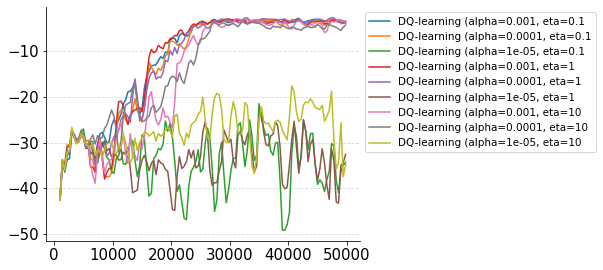

In [15]:
# best, best
### These filenames will be according to how the hyperparameter configurations are split
### for the available compute resources.
filenames = [
        "puckworld_50k_15.npy",
        "puckworld_50k_16.npy",
        "puckworld_50k_17.npy",
        "puckworld_50k_18.npy",
        "puckworld_50k_19.npy",
        "puckworld_50k_20.npy",
        "puckworld_50k_21.npy",
        "puckworld_50k_22.npy",
        "puckworld_50k_23.npy",
        
        #"AC_DiffQ_eps_0.1_1-5_27.npy",
    ]
    
plot_learning_curve_control(filenames, title='AC_all_eps_0.1_best', window=1000,
                            sample=400, firstn=-1, location='./results/control/puckworld_50k_DQL/') #window2000 and sample800